In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization,Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam
from PIL import Image 
import numpy as np
import re
import os 
import glob 
import random
import logging
from tensorflow.keras import backend as K
import math
tf.get_logger().setLevel(logging.ERROR)

In [2]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same", use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p


def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


def build_unet(input_shape, n_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    c1, p1 = encoder_block(inputs, 16)
    c2, p2 = encoder_block(p1, 32)
    c3, p3 = encoder_block(p2, 64)
    c4, p4 = encoder_block(p3, 128)

    c5 = conv_block(p4, 256) #Bridge
    c6 = decoder_block(c5, c4, 128)
    c7 = decoder_block(c6, c3, 64)
    c8 = decoder_block(c7, c2, 32)
    c9 = decoder_block(c8, c1, 16)

    if n_classes == 1:  #Binary
        activation = 'sigmoid'
    else:
        activation = 'softmax'
    
    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(c9)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [3]:
class DataReader(object):
    def __init__(self, img_dir, mask_dir, is_training=True, img_size=(128, 128)):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
#         self.imgs_path = glob.glob(f"{self.img_dir}/*.jpg")
        self.imgs_path = self.load_imgs(img_dir)
        self.num_imgs = len(self.imgs_path)
        self.img_h, self.img_w = img_size
        self.is_training = is_training
    
    
    def load_imgs(self, folders):
        self.imgs_path = []
        for folder in folders:
            imgs = glob.glob(f"{folder}/images/*.jpg")
            print(len(imgs))
            self.imgs_path.extend(imgs)
        
        return self.imgs_path
    
    def __len__(self):
        return self.num_imgs
    
    
    def find_mask(self, img_path):
        mask_path = re.sub("/images/", "/masks/", img_path)
        mask_path = re.sub(".jpg", ".png", mask_path)
        return mask_path if os.path.exists(mask_path) else None
    
    
    def load_normalized_resize_img(self, img_path, is_mask=False, resize_method=tf.image.ResizeMethod.BILINEAR):
        img = tf.io.read_file(img_path)
        channels = 1 if is_mask else 3
        # tf.image.decode_image if passing dtype=tf.float32, the value is range from [0,1] no need to normalized again 
        img = tf.image.decode_image(img, channels=channels, dtype=tf.float32)
        img = tf.image.resize_with_pad(img, self.img_h, self.img_w, method=resize_method)
        return img
        
    
    def __getitem__(self, index):
        img_path = self.imgs_path[index]
        mask_path = self.find_mask(img_path)
        
        img = self.load_normalized_resize_img(img_path)
        if mask_path:
            mask = self.load_normalized_resize_img(mask_path, is_mask=True)
        else:
            mask = tf.zeros((self.img_h, self.img_w, 1), dtype=tf.float32)
        mask = tf.where(mask > 0, 1., 0)
        
        if self.is_training:
            img, mask = self.geo_transform(img, mask)
            img = self.color_transform(img)
            img = tf.clip_by_value(img, 0, 1)
        
        return img, mask 
    
    
    def iter(self):
        for i in range(self.num_imgs):
            yield self[i]
            
    
    def geo_transform(self, img, mask):
        random_number = random.random()
        if random_number < 0.2:
            img = tf.image.flip_left_right(img)
            mask = tf.image.flip_left_right(mask)
        elif random_number < 0.4:
            img = tf.image.flip_up_down(img)
            mask = tf.image.flip_up_down(mask)
        elif random_number < 0.6:
            img = tf.image.rot90(img, 1)
            mask = tf.image.rot90(mask, 1)
        elif random_number < 0.8:
            img = tf.image.rot90(img, 3)
            mask = tf.image.rot90(mask, 3)
        return img, mask 
    
    
    def color_transform(self, img):
        random_number = random.random()
        if random_number < 0.2:
            img = tf.image.adjust_gamma(img, 0.6)
        elif random_number < 0.6:
            img = tf.image.random_brightness(img, max_delta=0.1)
        return img

In [4]:
"""
Loss function and metrics
"""
def jaccard_coefficient(y_true, y_pred, smooth=1.):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred) 
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection
    return (intersection + smooth) / (union + smooth)


def jaccard_loss(y_true, y_pred):
    return 1 - jaccard_coefficient(y_true, y_pred)


def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

# Trainning

In [5]:
!ls /seg_data/v3_finetune_seg_100424_frame_step_5/images | wc -l
# v3_finetune_seg_100424_frame_step_5

903


In [6]:
img_dirs = glob.glob("/seg_data/*")
img_dirs.pop(0)
img_dirs

['/seg_data/v3_finetune_seg_080424',
 '/seg_data/v3_finetune_seg_100424_frame_step_5',
 '/seg_data/task_v4_finetune_seg_120424',
 '/seg_data/task_v4_finetune_seg_160424',
 '/seg_data/v5_finetune']

In [5]:
strategy = tf.distribute.MirroredStrategy()
NUM_REPLICAS = strategy.num_replicas_in_sync
BATCH_PER_REPLICAS = 32
GLOBAL_BATCH = BATCH_PER_REPLICAS * NUM_REPLICAS
AUTOTUNE = tf.data.experimental.AUTOTUNE

# img_dir = "/seg_data/v3_finetune_seg_100424_frame_step_5/images"
label_dir = "/seg_data/v3_finetune_seg_100424_frame_step_5/masks"

img_dirs = glob.glob("/seg_data/*")
img_dirs.pop(0)
data_reader = DataReader(img_dirs, label_dir, is_training=True, img_size=(128, 128))
dataset = tf.data.Dataset.from_generator(data_reader.iter,
                                         output_types=(tf.float32, tf.float32),
                                         output_shapes=([128, 128, 3], [128, 128, 1]))
dataset = dataset.batch(GLOBAL_BATCH, drop_remainder=True).prefetch(AUTOTUNE)
# dataset = strategy.experimental_distribute_dataset(dataset)

num_examples = len(data_reader)
print(num_examples)
steps_per_epoch = num_examples // GLOBAL_BATCH

1754
903
881
2608
4970
11116


In [6]:
import matplotlib.pyplot as plt

def visualize(original, augmented, figure_size=(10,5)):
    fig = plt.figure(figsize=figure_size)
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

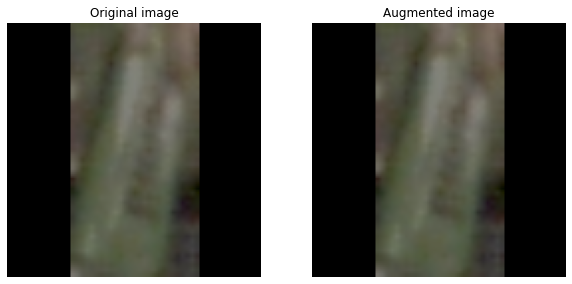

In [29]:
example = next(iter(dataset))
example1 = example[0][8]
visualize(example1, example1)

In [8]:
with strategy.scope():
    model = build_unet(input_shape=(128,128,3), n_classes=1)
    model.load_weights("/app/seg/models/v4_finetune_seg_180424.h5")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss=jaccard_loss, metrics=[jaccard_coefficient])
#, steps_per_epoch=steps_per_epoch
history = model.fit(dataset, epochs=100)

Epoch 1/100
86/86 [==============================] - 111s 1s/step - loss: 0.1275 - jaccard_coefficient: 0.8725
Epoch 2/100
86/86 [==============================] - 115s 1s/step - loss: 0.1311 - jaccard_coefficient: 0.8689
Epoch 3/100
86/86 [==============================] - 110s 1s/step - loss: 0.1298 - jaccard_coefficient: 0.8702
Epoch 4/100
86/86 [==============================] - 110s 1s/step - loss: 0.1284 - jaccard_coefficient: 0.8716
Epoch 5/100
86/86 [==============================] - 113s 1s/step - loss: 0.1264 - jaccard_coefficient: 0.8736
Epoch 6/100
86/86 [==============================] - 112s 1s/step - loss: 0.1262 - jaccard_coefficient: 0.8738
Epoch 7/100
86/86 [==============================] - 118s 1s/step - loss: 0.1271 - jaccard_coefficient: 0.8729
Epoch 8/100
86/86 [==============================] - 124s 1s/step - loss: 0.1241 - jaccard_coefficient: 0.8759
Epoch 9/100
86/86 [==============================] - 121s 1s/step - loss: 0.1229 - jaccard_coefficient: 0.8771
E

In [9]:
history = model.fit(dataset, epochs=200)

Epoch 1/200
86/86 [==============================] - 113s 1s/step - loss: 0.0873 - jaccard_coefficient: 0.9127
Epoch 2/200
86/86 [==============================] - 109s 1s/step - loss: 0.0873 - jaccard_coefficient: 0.9127
Epoch 3/200
86/86 [==============================] - 108s 1s/step - loss: 0.0862 - jaccard_coefficient: 0.9138
Epoch 4/200
86/86 [==============================] - 110s 1s/step - loss: 0.0866 - jaccard_coefficient: 0.9134
Epoch 5/200
86/86 [==============================] - 114s 1s/step - loss: 0.0861 - jaccard_coefficient: 0.9139
Epoch 6/200
86/86 [==============================] - 116s 1s/step - loss: 0.0862 - jaccard_coefficient: 0.9138
Epoch 7/200
86/86 [==============================] - 111s 1s/step - loss: 0.0861 - jaccard_coefficient: 0.9139
Epoch 8/200
86/86 [==============================] - 112s 1s/step - loss: 0.0865 - jaccard_coefficient: 0.9135
Epoch 9/200
86/86 [==============================] - 108s 1s/step - loss: 0.0872 - jaccard_coefficient: 0.9128
E

KeyboardInterrupt: 

In [10]:
model.save("/app/seg/models/v5_finetune.h5")